# Version 2: Polynomial Ridge Regression

## Introduction: Changes & Purpose
In Version 2, we introduced polynomial feature expansion combined with Ridge Regression.
- **Change:** Added polynomial features (up to a specified degree) to capture non-linear relationships in the data.
- **Purpose:** This modification aimed to enhance model flexibility and better capture complex patterns, resulting in significantly improved performance compared to the baseline linear regression model.




🚀 Version 2 - RMSE: 216.50, R²: 0.9950


2025/03/15 23:32:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ MLflow run completed!


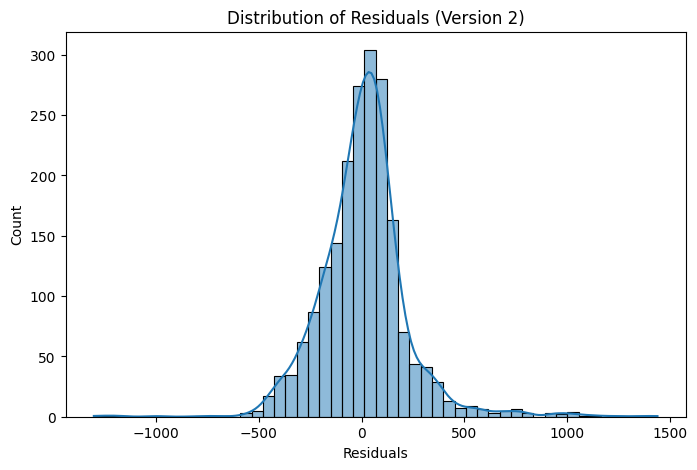

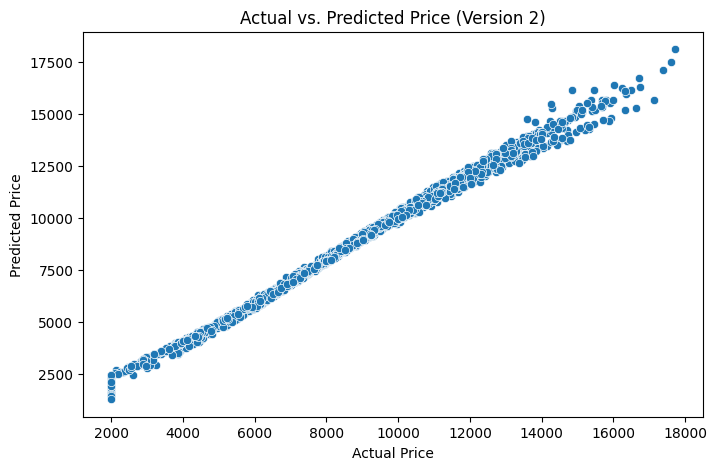

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Initialize MLflow experiment
mlflow.set_experiment("Car Price Prediction - Version 2")

with mlflow.start_run():
    #  Load data
    df = pd.read_csv("car_price_dataset.csv")

    # Remove unrealistic values based on Version 1 (Boxplot analysis)
    df = df[(df["Price"] >= 2000) & (df["Price"] <= 18000)]
    df = df[(df["Mileage"] >= 0) & (df["Mileage"] <= 300000)]
    df = df[(df["Engine_Size"] >= 0.8) & (df["Engine_Size"] <= 6.0)]
    df["Car_Age"] = 2025 - df["Year"]
    
    # Label encoding for categorical data
    categorical_columns = ["Brand", "Model", "Fuel_Type", "Transmission"]
    label_encoders = {}

    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Feature engineering: Transform mileage
    df["Mileage_sqrt"] = np.sqrt(df["Mileage"])

    # Remove unnecessary columns
    df.drop(columns=["Year", "Mileage"], inplace=True)

    # Standardize numerical features
    scaler = StandardScaler()
    numeric_features = ["Engine_Size", "Mileage_sqrt", "Car_Age", "Doors"]
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    # Transform target variable
    df["Log_Price"] = np.log1p(df["Price"])

    # Create training and test data
    X = df.drop(columns=["Price", "Log_Price"])
    y = df["Log_Price"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Machine learning pipeline with polynomial features + Ridge regression
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(include_bias=False)),
        ('scaler', StandardScaler()),
        ('ridge', Ridge())
    ])

    # Hyperparameter optimization with GridSearchCV
    param_grid = {
        "poly__degree": [1, 2, 3],
        "ridge__alpha": [0.1, 1, 10]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="neg_mean_squared_error")
    grid_search.fit(X_train, y_train)

    # Extract best model
    best_model = grid_search.best_estimator_
    mlflow.log_params(grid_search.best_params_)
    
    # Evaluate model
    y_pred_log = best_model.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
    r2 = r2_score(np.expm1(y_test), y_pred)

    print(f" Version 2 - RMSE: {rmse:.2f}, R²: {r2:.4f}")

    # Log metrics in MLflow
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2_Score", r2)

    #  Save model
    with open("ridge_model_v2.pkl", "wb") as f:
        pickle.dump(best_model, f)

    mlflow.sklearn.log_model(best_model, "ridge_model_v2")

    print("✅ MLflow run completed!")

    #  Generate plots
    plt.figure(figsize=(8, 5))
    sns.histplot(np.expm1(y_test) - y_pred, bins=50, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Count")
    plt.title("Distribution of Residuals (Version 2)")
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=np.expm1(y_test), y=y_pred)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Actual vs. Predicted Price (Version 2)")
    plt.show()


## Results Discussion
The model in Version 2 achieved an RMSE of *216.50* and an R² of *0.9950* on the test set.  
These results suggest that the addition of polynomial features greatly improved the model's ability to capture underlying patterns in the data. However, such a high R² warrants further cross-validation to ensure that overfitting is not an issue.
